In [65]:
import os
import random
import requests
import json
from tqdm import tqdm
from pprint import pprint
from natsort import natsorted

import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

PATH = os.path.join(os.getcwd(), 'data')
IMAGE_PATH = os.path.join(PATH, 'preprocessed images')
CHARACTER_PATH = os.path.join(IMAGE_PATH, 'chars_segmented')

# Metadata Plat

In [3]:
metadata = pd.read_csv(os.path.join(PATH, 'images', 'plates.csv'), sep=';', index_col=0)
metadata

,plate,bukan_biru,note
index,,,
1,g12201,NaN,NaN
2,gt9571,NaN,NaN
3,g02003,NaN,NaN
4,g12758,NaN,NaN
5,g05016,NaN,NaN
...,...,...,...
806,g04186,NaN,NaN
807,g0110,1.0,NaN
808,g00571,NaN,NaN


In [27]:
# Ambil yang nonbiru sesuai batasan masalah
metadata_non_biru = metadata[metadata['bukan_biru'] != 1][['plate']]
indeks_non_biru = metadata_non_biru.index.to_list()
for i in range(6):
    metadata_non_biru[f'char_{i}'] = metadata_non_biru['plate'].str[i]
metadata_non_biru

,plate,char_0,char_1,char_2,char_3,char_4,char_5
index,,,,,,,
1,g12201,g,1,2,2,0,1
2,gt9571,g,t,9,5,7,1
3,g02003,g,0,2,0,0,3
4,g12758,g,1,2,7,5,8
5,g05016,g,0,5,0,1,6
...,...,...,...,...,...,...,...
805,gt0367,g,t,0,3,6,7
806,g04186,g,0,4,1,8,6
808,g00571,g,0,0,5,7,1


In [ ]:
# plots = pd.DataFrame(natsorted(os.listdir(os.path.join(IMAGE_PATH, 'plots'))), columns=['file_name'])
# # plots['file_name'] = plots['file_name'].str.replace('.png', '')
# plots['index'] = plots['file_name'].str.split('_').str[0].astype('Int64')
# plots['segment_count'] = plots['file_name'].str.split('_').str[1]
# plots['segment_count'] = plots['segment_count'].str.split('.').str[0].astype(int)
# plots.set_index('index', inplace=True)
# # usable_index = plots[plots['segment_count'] == 6].index.to_list()

In [28]:
# Cari indeks dari preprocessed image yang layak digunakan

# six_file_names = plots[plots['segment_count'] == 6]['file_name'].values
# import shutil
# for file in six_file_names:
#     shutil.copy(os.path.join(IMAGE_PATH, 'plots', file), os.path.join(IMAGE_PATH, 'plots_6', file))
usable_index=[int(x.split('_')[0]) for x in natsorted(os.listdir(os.path.join(IMAGE_PATH, 'plots_6')))]
metadata_non_biru = metadata_non_biru[metadata_non_biru.index.isin(usable_index)]
metadata_non_biru

,plate,char_0,char_1,char_2,char_3,char_4,char_5
index,,,,,,,
1,g12201,g,1,2,2,0,1
3,g02003,g,0,2,0,0,3
4,g12758,g,1,2,7,5,8
5,g05016,g,0,5,0,1,6
6,g01466,g,0,1,4,6,6
...,...,...,...,...,...,...,...
791,g97015,g,9,7,0,1,5
794,gt1902,g,t,1,9,0,2
796,ghk520,g,h,k,5,2,0


# Load Gambar

In [31]:
# Load semua gambar karakter yang sudah tersegmen

for i in range(6):
    metadata_non_biru.loc[:, f'img_{i}'] = metadata_non_biru.apply(lambda x: cv2.imread(os.path.join(CHARACTER_PATH, f"{x.name}_{i}.png"), cv2.IMREAD_GRAYSCALE), axis=1)

In [33]:
metadata_non_biru.reset_index(inplace=True)
metadata_non_biru.head()

,index,plate,char_0,char_1,char_2,char_3,char_4,char_5,img_0,img_1,img_2,img_3,img_4,img_5
0,1,g12201,g,1,2,2,0,1,"[[0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, ...","[[0, 255, 255, 255, 0, 0], [255, 255, 255, 255...","[[0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 25...","[[0, 0, 0, 255, 255, 255, 255, 255, 255, 255, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, ...","[[0, 0, 255, 255, 0], [0, 255, 255, 255, 255],..."
1,3,g02003,g,0,2,0,0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, ...","[[0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 2...","[[0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0...","[[0, 255, 255, 255, 255, 255, 255, 255, 255, 2..."
2,4,g12758,g,1,2,7,5,8,"[[0, 0, 255, 255, 255, 255, 255, 255, 255, 255...","[[0, 255, 0, 0, 0, 0], [0, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ...","[[0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 25..."
3,5,g05016,g,0,5,0,1,6,"[[0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255...","[[0, 0, 255, 255, 255, 255, 255, 255, 255, 255...","[[0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 2...","[[0, 0, 0, 255, 255], [0, 0, 255, 255, 255], [...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 2..."
4,6,g01466,g,0,1,4,6,6,"[[0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 25...","[[0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255,...","[[0, 255, 255, 0, 0], [255, 255, 255, 255, 255...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0,..."


# Train-Test Split

In [ ]:
train_data, test_data = train_test_split(metadata_non_biru, test_size=0.3, random_state=57)

In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 317 to 214
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   296 non-null    int64 
 1   plate   296 non-null    object
 2   char_0  296 non-null    object
 3   char_1  296 non-null    object
 4   char_2  296 non-null    object
 5   char_3  296 non-null    object
 6   char_4  296 non-null    object
 7   char_5  296 non-null    object
 8   img_0   296 non-null    object
 9   img_1   296 non-null    object
 10  img_2   296 non-null    object
 11  img_3   296 non-null    object
 12  img_4   296 non-null    object
 13  img_5   296 non-null    object
dtypes: int64(1), object(13)
memory usage: 34.7+ KB


In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 147 to 363
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   128 non-null    int64 
 1   plate   128 non-null    object
 2   char_0  128 non-null    object
 3   char_1  128 non-null    object
 4   char_2  128 non-null    object
 5   char_3  128 non-null    object
 6   char_4  128 non-null    object
 7   char_5  128 non-null    object
 8   img_0   128 non-null    object
 9   img_1   128 non-null    object
 10  img_2   128 non-null    object
 11  img_3   128 non-null    object
 12  img_4   128 non-null    object
 13  img_5   128 non-null    object
dtypes: int64(1), object(13)
memory usage: 15.0+ KB


# Ekstraksi Fitur (HOG)

In [71]:
def separate_chars(metadata, col_name):
    left_temp = metadata[['index', 'plate', 'char_0', f'{col_name}_0']].rename(columns={'char_0': 'char', f'{col_name}_0': f'{col_name}'})
    left_temp['order'] = 0

    for i in range(1, 6):
        right_temp = metadata[['index', 'plate', f'char_{i}', f'{col_name}_{i}']].rename(columns={f'char_{i}': 'char', f'{col_name}_{i}': f'{col_name}'})
        right_temp['order'] = i
        left_temp = pd.concat([left_temp, right_temp]).sort_values(['index', 'order']).reset_index(drop=True)
    return left_temp

In [ ]:
train_data = separate_chars(train_data, 'img')
train_data

,index,plate,char,img,order
0,1,g12201,g,"[[0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, ...",0
1,1,g12201,1,"[[0, 255, 255, 255, 0, 0], [255, 255, 255, 255...",1
2,1,g12201,2,"[[0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 25...",2
3,1,g12201,2,"[[0, 0, 0, 255, 255, 255, 255, 255, 255, 255, ...",3
4,1,g12201,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 255, ...",4
...,...,...,...,...,...
1771,808,g00571,0,"[[0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 255,...",1
1772,808,g00571,0,"[[0, 0, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, ...",2
1773,808,g00571,5,"[[0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 25...",3
1774,808,g00571,7,"[[0, 0, 255, 255, 255, 255, 0, 255, 255, 0, 0]...",4


In [51]:
def resize_image(image, size=(32, 32)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def extract_hog_features(image):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    return fd, hog_image

train_data.loc[:,'img'] = train_data['img'].apply(lambda img: resize_image(img))
train_data['hog_features'] = train_data['img'].apply(lambda img: extract_hog_features(np.array(img))[0])
train_data['hog_image'] = train_data['img'].apply(lambda img: extract_hog_features(np.array(img))[1])

# Training

In [ ]:
X_train = np.array(train_data['hog_features'].tolist())
y_train = train_data['char']

# Create and train the random forest classifier
clf = RandomForestClassifier( random_state=57)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=57)

# Testing

In [ ]:
for i in range(6):
    test_data.loc[:, f'img_{i}'] = test_data[f'img_{i}'].apply(lambda img: resize_image(img))
    test_data.loc[:, f'hog_features_{i}'] = test_data[f'img_{i}'].apply(lambda img: extract_hog_features(np.array(img))[0])
    test_data.loc[:, f'hog_image_{i}'] = test_data[f'img_{i}'].apply(lambda img: extract_hog_features(np.array(img))[1])
    test_data.loc[:, f'pred_{i}'] = test_data[f'hog_features_{i}'].apply(lambda img: clf.predict([img])[0])

In [ ]:
test_data.loc[:, 'plate_pred'] = test_data.apply(lambda x: ''.join(x[f'pred_{i}'] for i in range(6)), axis=1)

# Evaluasi

In [ ]:
# Akurasi berdasarkan benar atau salah untuk keseluruhan plat
accuracy = accuracy_score(test_data['plate'], test_data['plate_pred'])
print(f'Akurasi: {accuracy * 100:.2f}%')

Akurasi: 82.81%


In [75]:
# Classification report untuk prediksi per karakter
all_preds = separate_chars(test_data, 'pred')
report = classification_report(all_preds['char'], all_preds['pred'])
print(report)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        84
           1       0.96      1.00      0.98        82
           2       0.95      1.00      0.98        59
           3       1.00      0.98      0.99        48
           4       0.91      1.00      0.95        20
           5       0.96      0.98      0.97        53
           6       1.00      1.00      1.00        57
           7       0.94      1.00      0.97        44
           8       0.96      1.00      0.98        52
           9       1.00      0.98      0.99        56
           a       0.88      1.00      0.93         7
           b       1.00      0.50      0.67         2
           c       1.00      0.50      0.67         2
           d       1.00      0.50      0.67         4
           e       1.00      1.00      1.00         2
           f       1.00      1.00      1.00         3
           g       1.00      0.98      0.99       119
           h       1.00    

c:\Users\abdzu\Documents\College\9th Semester\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdzu\Documents\College\9th Semester\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abdzu\Documents\College\9th Semester\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

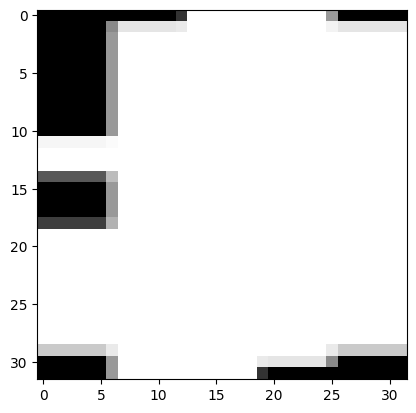

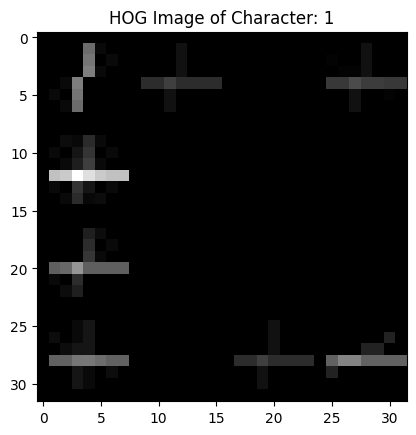

In [ ]:
# idx = 5
# plt.imshow(cleaned_characters['img'].iloc[idx], cmap='gray')
# # plt.title(f"HOG Image of Character: {cleaned_characters['char'].iloc[idx]}")
# plt.show()
# plt.imshow(cleaned_characters['hog_image'].iloc[idx], cmap='gray')
# plt.title(f"HOG Image of Character: {cleaned_characters['char'].iloc[idx]}")
# plt.show()